In [54]:
# -*- coding: utf-8 -*-
'''
This script retrieves twitter and Binance data and write it into input_path(default: "input/data.csv") every minute (t min 04 sec);
then it waits spark to output the prediction into output_path(default: "output/data.csv"), where the prediction column name should be "close";
then it plots the close price in the past 60 minutes and the predicted future close price in 5 minutes every minute.
Adjustable parameters:
input_path(="input/data.csv"): where this script wrtites twitter and Binance data
output_path(="output/data.csv"): where spark writes predicted price
wait(=5): the seconds needed for spark to predict
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from tqdm import tnrange, tqdm_notebook, tqdm
import nltk
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
except:
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import json
import os
import random
import subprocess
import time
from datetime import date, datetime, timedelta
import requests

from twython import Twython
from time import sleep
import io

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")


'''Part2 Price'''
API_BASE = 'https://api.binance.com/api/v3/'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def set_dtypes(df):
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    # df = df.set_index('open_time', drop=True)
    print(df.columns)

    df = df.astype(dtype={
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'volume': 'float64',
        'quote_asset_volume': 'float64',
        'number_of_trades': 'int64',
        'taker_buy_base_asset_volume': 'float64',
        'taker_buy_quote_asset_volume': 'float64'
        # 'ignore': 'float64'
    })
    return df


def quick_clean(df):
    # drop dupes
    dupes = df['open_time'].duplicated().sum()
    if dupes > 0:
        df = df[df['open_time'].duplicated() == False]

    # sort by timestamp, oldest first
    df.sort_values(by=['open_time'], ascending=False)

    df.drop(['close_time', 'ignore'], axis=1, inplace=True)

    return df


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.ConnectionResetError:
        print('Connection reset by peer, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    print(f'Got erroneous response back: {response}')
    return pd.DataFrame([])


def ExtractPrice(t):
    base = 'BTC'
    quote = 'BUSD'
    t = time.strptime(t, '%Y-%m-%d %H:%M:%S')
    timeStamp = int(time.mktime(t)) * 1000

    new_batch = get_batch(symbol=base + quote,
                          interval='1m',
                          start_time=timeStamp)
    new_batch = quick_clean(new_batch)
    new_batch = set_dtypes(new_batch)
    return new_batch


'''Part3 Preprocess'''


def Preprocess(t):
    #tweets_raw_file = ExtractTwitter(t)
    tweets_raw_file = pd.read_parquet('twitter_score/', engine='pyarrow')
    tweets_df = tweets_raw_file[['end_time','score','weighted_score']]\
        .rename(columns={'end_time': 'open_time',
                 'score': 'avg', 
                 'weighted_score': 'wgtavg'})
    pricedf = ExtractPrice(t)
    pricedf = pricedf.iloc[-60:,:]
    data = pd.merge(tweets_df, pricedf, how='right', on='open_time').fillna({'avg': 0.0, 'wgtavg': 0.0})
#     print(data.head(20))
    return data


'''#Part4 Plot Prediction'''
def plot_price(data, output_list, fig, wait):
    plt.pause(wait)
    #print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    plt.clf()
    plt.plot(np.arange(-59,1,1),data['close'],label='Past price')
    plt.plot(np.arange(1,6),output_list,'y--',label='Future price prediction')
    plt.xticks(np.arange(-60, 6, 5))
    plt.xlabel('Time (minutes from now)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    fig.canvas.flush_events()
    #print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    plt.pause(10)

Index(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'],
      dtype='object')
feature collection latency: 0.600 sec
gbdt latency: 0.007 sec
lstm latency: 0.000 sec
total latency: 0.607 sec


<Figure size 720x432 with 0 Axes>

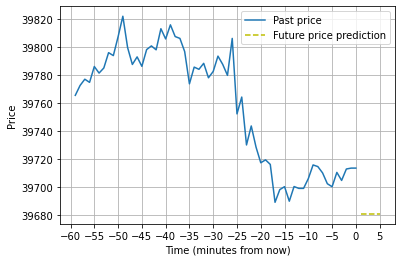

Index(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'],
      dtype='object')
feature collection latency: 0.628 sec
gbdt latency: 0.006 sec
lstm latency: 0.000 sec
total latency: 0.634 sec


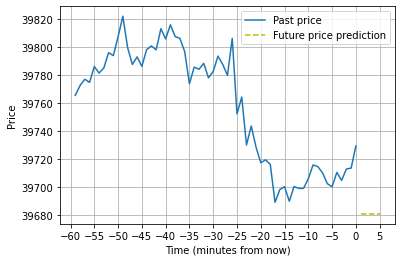

Index(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'],
      dtype='object')
feature collection latency: 5.230 sec
gbdt latency: 0.015 sec
lstm latency: 0.001 sec
total latency: 5.247 sec


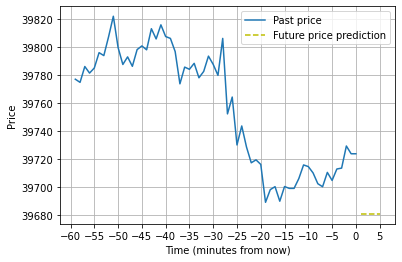

Index(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'],
      dtype='object')
feature collection latency: 1.134 sec
gbdt latency: 0.006 sec
lstm latency: 0.001 sec
total latency: 1.141 sec


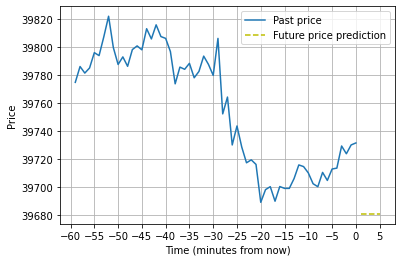

KeyboardInterrupt: 

In [65]:
"""# Part5 Data Streaming"""
if __name__=='__main__':
    input_path = 'input/data.csv'
    output_path = 'output/data.csv'
    wait=5
    
    plt.ion()
    fig=plt.figure(num=1,figsize=(10,6))
    while True:
        now=int(time.strftime('%S', time.localtime(time.time())))
        if now!=4:
            time.sleep(0.5)
            continue

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time() - 60 * 60 - 8 * 60 * 60))
        
        start_timestamp = datetime.now()
        data = Preprocess(t)
        feature_collection_timestamp = datetime.now()
        print('feature collection latency: %.3f sec' % (feature_collection_timestamp-start_timestamp).total_seconds())
        data.to_csv(input_path, index=False) # can deprecate

        # TODO: model prediction
#         data = pd.read_csv('input/data.csv') # uncomment for offline test
        input_list = data.to_numpy().flatten().tolist()
        # 1. gbdt
        # output_gbdt = predict2(input_list)
        # output_gbdt: [t1, t2, t3, t4, t5]
        
        
        
        output_gbdt = [39680.7, 39680.7, 39680.7, 39680.7, 39680.7] #sample
         
        gbdt_timestamp = datetime.now()
        print('gbdt latency: %.3f sec' % (gbdt_timestamp-feature_collection_timestamp).total_seconds())
        
        #2. lstm
        # output_lstm = predict2(input_list)
        # output_lstm: [t1, t2, t3, t4, t5]
        
        
        
        output_lstm = [39680.7, 39680.7, 39680.7, 39680.7, 39680.7]
        
        lstm_timestamp = datetime.now()
        print('lstm latency: %.3f sec' % (lstm_timestamp-gbdt_timestamp).total_seconds())
        print('total latency: %.3f sec' % (lstm_timestamp-start_timestamp).total_seconds())
        
        w_gbdt = 0.5
        w_lstm = 1 - w_gbdt
        final_output = [w_gbdt * output_gbdt[i]  + w_lstm * output_gbdt[i] for i in range(5)]
        
        plot_price(data,final_output,fig,wait)